<a href="https://colab.research.google.com/github/spesivan/colab-notes-v2/blob/main/pytorch_unet_training_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

In [2]:
!git clone https://github.com/spesivan/unet_pyt.git

Cloning into 'unet_pyt'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 42 (delta 8), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (42/42), 21.09 KiB | 469.00 KiB/s, done.
Resolving deltas: 100% (8/8), done.


In [3]:
!pip install getpass
!pip install roboflow --quiet
from getpass import getpass
from roboflow import Roboflow



api_key = getpass('Enter YOUR_API_KEY secret value: ')

# bYbWrPpLt1yNAM2mBTmX
# https://universe.roboflow.com/university-bswxt/crack-bphdr
rf = Roboflow(api_key=api_key)
project = rf.workspace("university-bswxt").project("crack-bphdr")
dataset = project.version(2).download("coco-segmentation")

ERROR: Could not find a version that satisfies the requirement getpass (from versions: none)
ERROR: No matching distribution found for getpass
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.6 MB/s eta 0:00:00
Enter YOUR_API_KEY secret value: ··········
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to crack-2 in coco-segmentation:: 100%|██████████| 4037/4037 [00:00<00:00, 6618.62it/s]


In [4]:
!pwd
!mv crack-2/valid unet_pyt
!mv crack-2/test unet_pyt

/content


In [5]:
!rm -rf crack-2

In [6]:
!mv unet_pyt/valid unet_pyt/train

In [7]:
import os
import json
import numpy as np # type: ignore
import cv2 # type: ignore

os.chdir('/content/unet_pyt')

# Dosya yolları
input_dir = 'train'  # Orjinal resimlerin bulunduğu klasör
output_dir = f'output_{input_dir}'  # Çıktı klasörü
images_dir = os.path.join(output_dir, 'image')  # Çıktı resimler klasörü
masks_dir = os.path.join(output_dir, 'mask')  # Çıktı maskeler klasörü

# Klasörleri oluştur
os.makedirs(images_dir, exist_ok=True)
os.makedirs(masks_dir, exist_ok=True)

# JSON dosyasını oku
with open(f'{input_dir}/_annotations.coco.json') as file:
    data = json.load(file)

# Görüntü bilgilerini bir sözlükte sakla
images_info = {item['id']: item for item in data['images']}
annotations_per_image = {}

# Her annotasyon için maske oluştur
for annotation in data['annotations']:
    image_id = annotation['image_id']
    if image_id not in annotations_per_image:
        annotations_per_image[image_id] = []
    annotations_per_image[image_id].append(annotation)

# Her resim için tüm segmentasyonları birleştir
for image_id, annotations in annotations_per_image.items():
    image_info = images_info[image_id]
    image_path = os.path.join(input_dir, image_info['file_name'])
    mask_path = os.path.join(masks_dir, os.path.splitext(image_info['file_name'])[0] + '.png')

    # Görüntüyü yükle
    image = cv2.imread(image_path)
    if image is None:
        continue

    # Maske için boş bir görüntü oluştur
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # Tüm segmentasyonları maske üzerinde çiz
    for annotation in annotations:
        for seg in annotation['segmentation']:
            poly = np.array(seg, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(mask, [poly], 255)

    # Görüntü ve maskeyi yeniden boyutlandır
    resized_image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_AREA)
    resized_mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)

    # Maskeyi ve görüntüyü kaydet
    cv2.imwrite(mask_path, resized_mask)
    cv2.imwrite(os.path.join(images_dir, os.path.splitext(image_info['file_name'])[0] + '.png'), resized_image)

print("Resimler ve maskeler 512x512 boyutunda oluşturuldu ve .png formatında kaydedildi.")


Resimler ve maskeler 512x512 boyutunda oluşturuldu ve .png formatında kaydedildi.


In [8]:
import os
import json
import numpy as np # type: ignore
import cv2 # type: ignore

os.chdir('/content/unet_pyt')

# Dosya yolları
input_dir = 'test'  # Orjinal resimlerin bulunduğu klasör
output_dir = f'output_{input_dir}'  # Çıktı klasörü
images_dir = os.path.join(output_dir, 'image')  # Çıktı resimler klasörü
masks_dir = os.path.join(output_dir, 'mask')  # Çıktı maskeler klasörü

# Klasörleri oluştur
os.makedirs(images_dir, exist_ok=True)
os.makedirs(masks_dir, exist_ok=True)

# JSON dosyasını oku
with open(f'{input_dir}/_annotations.coco.json') as file:
    data = json.load(file)

# Görüntü bilgilerini bir sözlükte sakla
images_info = {item['id']: item for item in data['images']}
annotations_per_image = {}

# Her annotasyon için maske oluştur
for annotation in data['annotations']:
    image_id = annotation['image_id']
    if image_id not in annotations_per_image:
        annotations_per_image[image_id] = []
    annotations_per_image[image_id].append(annotation)

# Her resim için tüm segmentasyonları birleştir
for image_id, annotations in annotations_per_image.items():
    image_info = images_info[image_id]
    image_path = os.path.join(input_dir, image_info['file_name'])
    mask_path = os.path.join(masks_dir, os.path.splitext(image_info['file_name'])[0] + '.png')

    # Görüntüyü yükle
    image = cv2.imread(image_path)
    if image is None:
        continue

    # Maske için boş bir görüntü oluştur
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # Tüm segmentasyonları maske üzerinde çiz
    for annotation in annotations:
        for seg in annotation['segmentation']:
            poly = np.array(seg, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(mask, [poly], 255)

    # Görüntü ve maskeyi yeniden boyutlandır
    resized_image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_AREA)
    resized_mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)

    # Maskeyi ve görüntüyü kaydet
    cv2.imwrite(mask_path, resized_mask)
    cv2.imwrite(os.path.join(images_dir, os.path.splitext(image_info['file_name'])[0] + '.png'), resized_image)

print("Resimler ve maskeler 512x512 boyutunda oluşturuldu ve .png formatında kaydedildi.")


Resimler ve maskeler 512x512 boyutunda oluşturuldu ve .png formatında kaydedildi.


In [9]:
!rm -rf train
!rm -rf test

In [10]:
!mv output_train train
!mv output_test test

In [11]:
!mkdir new_data

In [12]:
!mv train new_data/
!mv test new_data/

In [13]:
os.chdir('/content/unet_pyt')
!pwd
!pip install -r requirements.txt

/content/unet_pyt
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-1

In [14]:
os.chdir('/content')

In [15]:
import torch
torch.cuda.is_available()

True

In [16]:
!nvidia-smi

Fri May  3 22:01:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              24W / 300W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [17]:
os.chdir('/content/unet_pyt/UNET')
!pwd

/content/unet_pyt/UNET


In [18]:
!python3 train.py

Dataset Size:
Train: 199 - Valid: 112

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Valid loss improved from inf to 1.1624. Saving checkpoint: files/checkpoint.pth
Epoch: 01 | Epoch Time: 0m 33s
	Train Loss: 1.249
	 Val. Loss: 1.162

Valid loss improved from 1.1624 to 1.0914. Saving checkpoint: files/checkpoint.pth
Epoch: 02 | Epoch Time: 0m 33s
	Train Loss: 1.107
	 Val. Loss: 1.091

Valid loss improved from 1.0914 to 1.0101. Saving checkpoint: files/checkpoint.pth
Epoch: 03 | Epoch Time: 0m 33s
	Train Loss: 1.037
	 Val. Loss: 1.010

Valid loss impro

In [19]:
!python3 test.py

 11% 12/112 [00:05<00:42,  2.36it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 18% 20/112 [00:08<00:39,  2.34it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100% 112/112 [00:48<00:00,  2.33it/s]
Jaccard: 0.5889 - F1: 0.7199 - Recall: 0.7865 - Precision: 0.7347 - Acc: 0.9896
FPS:  94.92295888541987


In [28]:
from IPython.display import Image, display

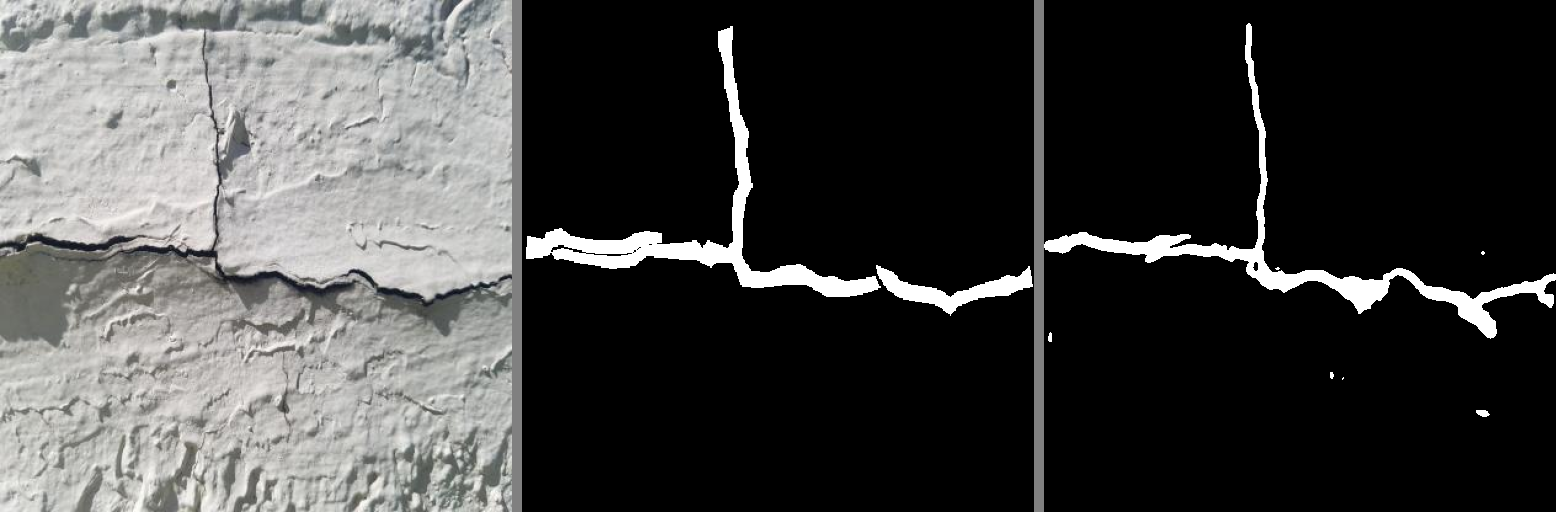

In [32]:
img = '/content/unet_pyt/UNET/results/1686.png'
display(Image(filename= img))

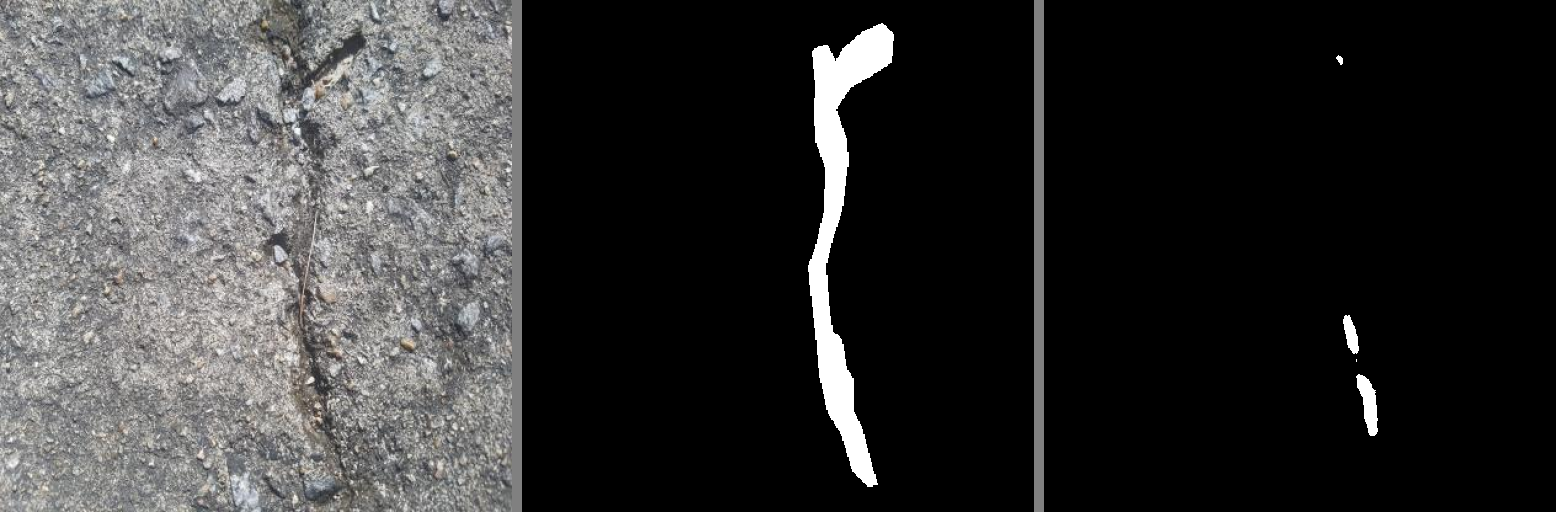

In [33]:
img = '/content/unet_pyt/UNET/results/1706.png'
display(Image(filename= img))

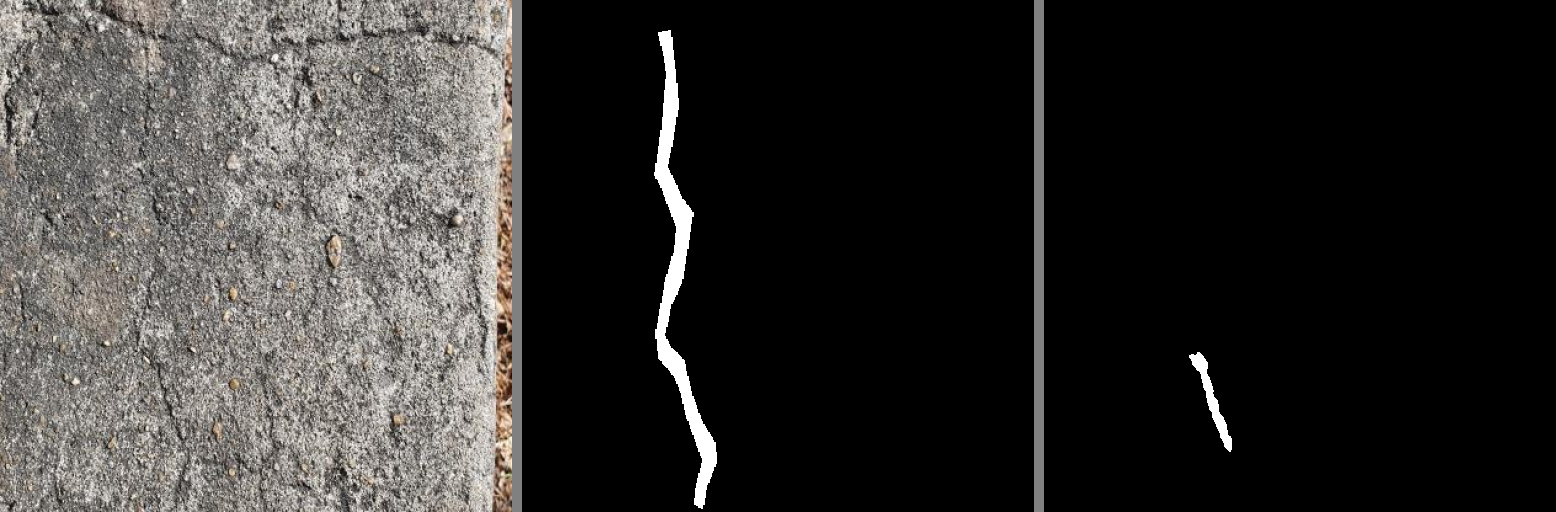

In [34]:
img = '/content/unet_pyt/UNET/results/1794.png'
display(Image(filename= img))

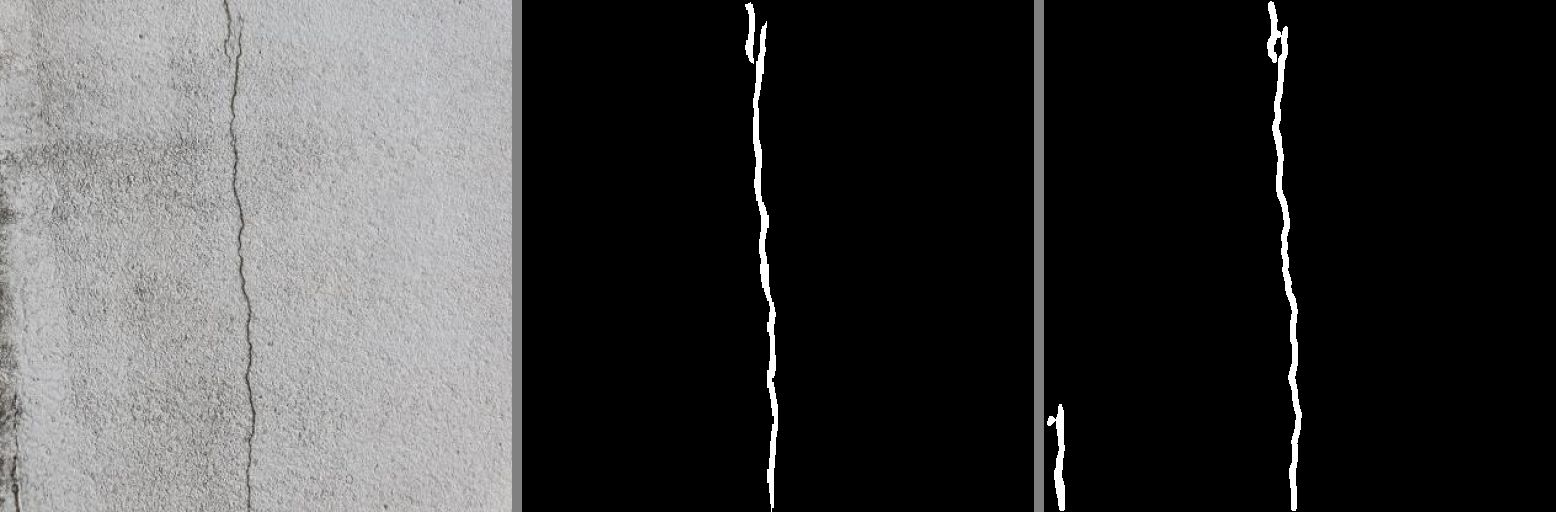

In [35]:
img = '/content/unet_pyt/UNET/results/2064.png'
display(Image(filename= img))

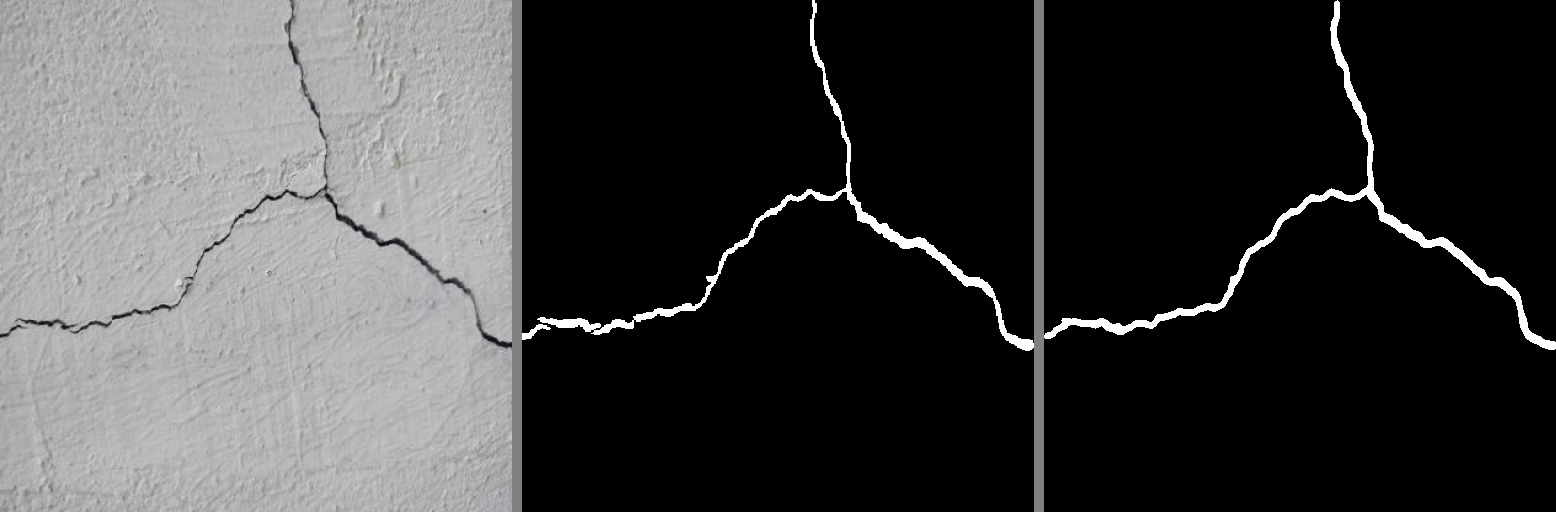

In [36]:
img = '/content/unet_pyt/UNET/results/2222.png'
display(Image(filename= img))

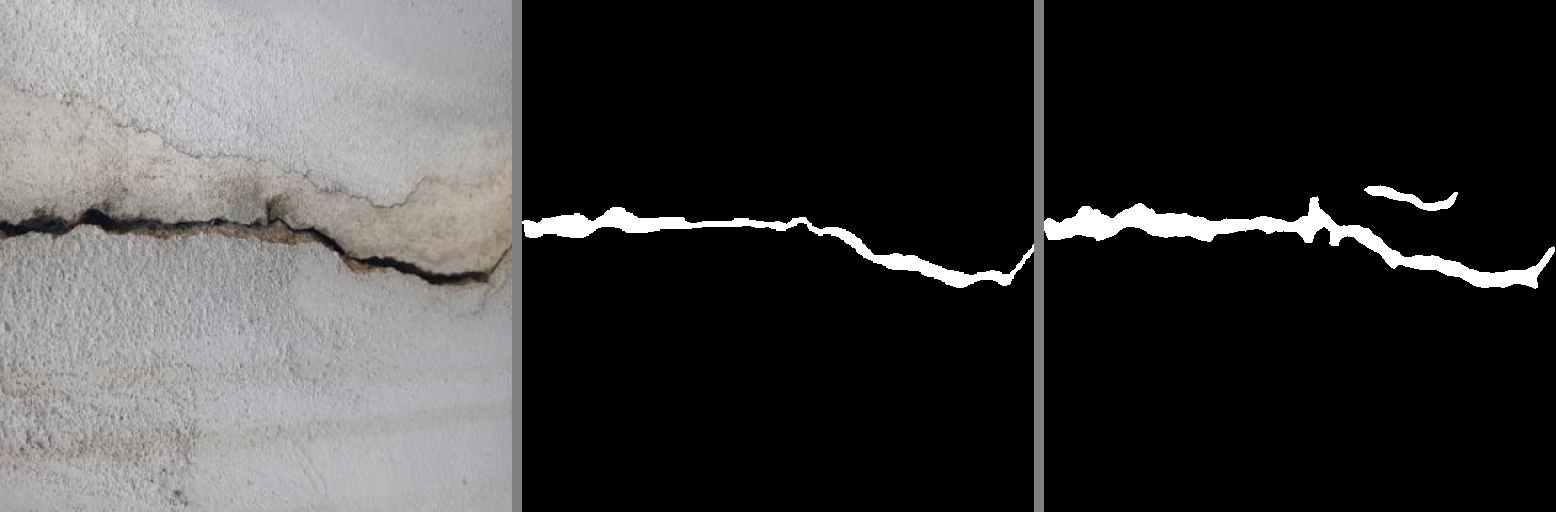

In [37]:
img = '/content/unet_pyt/UNET/results/2232.png'
display(Image(filename= img))

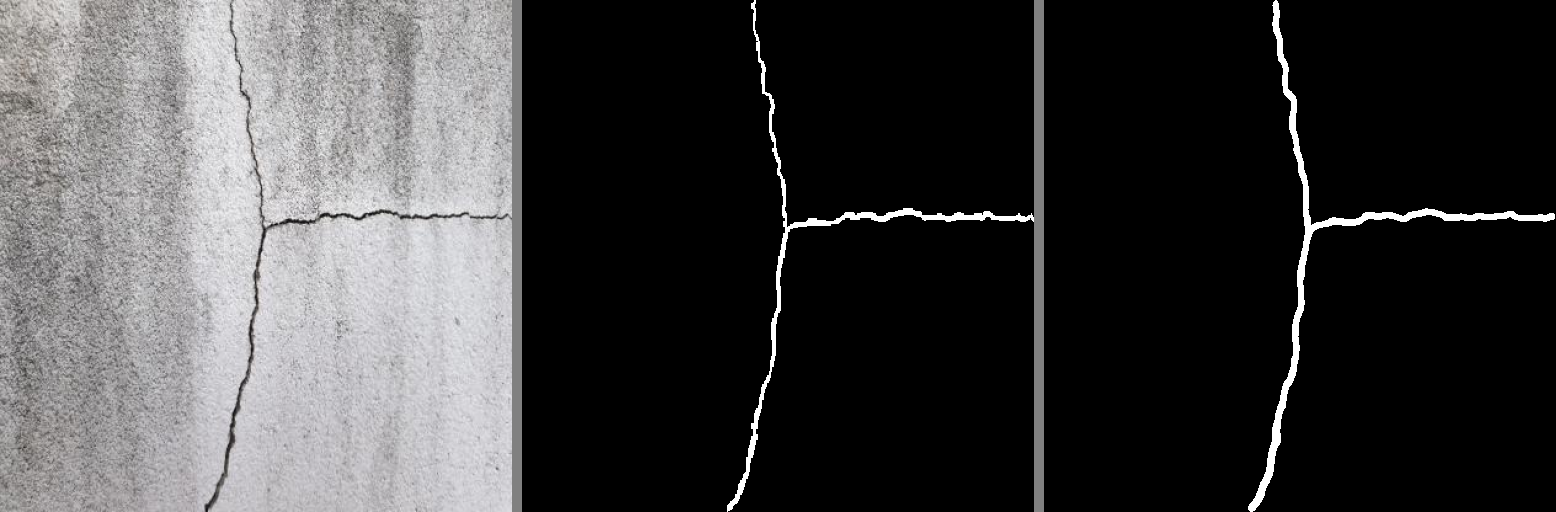

In [38]:
img = '/content/unet_pyt/UNET/results/2363.png'
display(Image(filename= img))

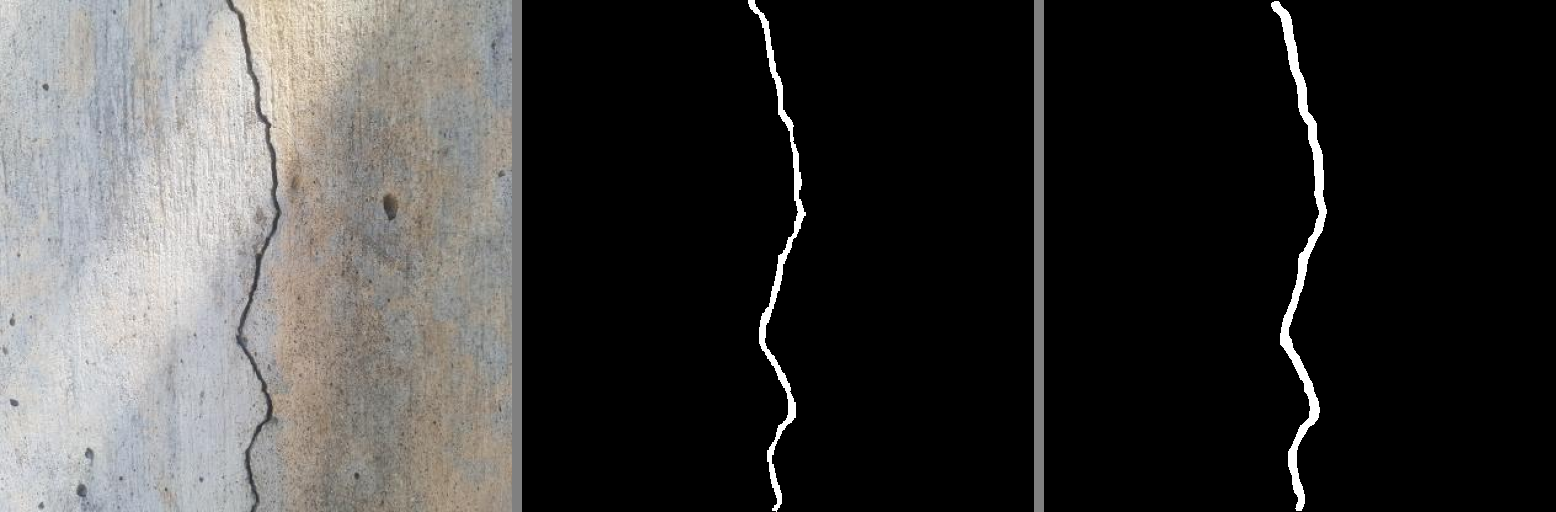

In [39]:
img = '/content/unet_pyt/UNET/results/2373.png'
display(Image(filename= img))

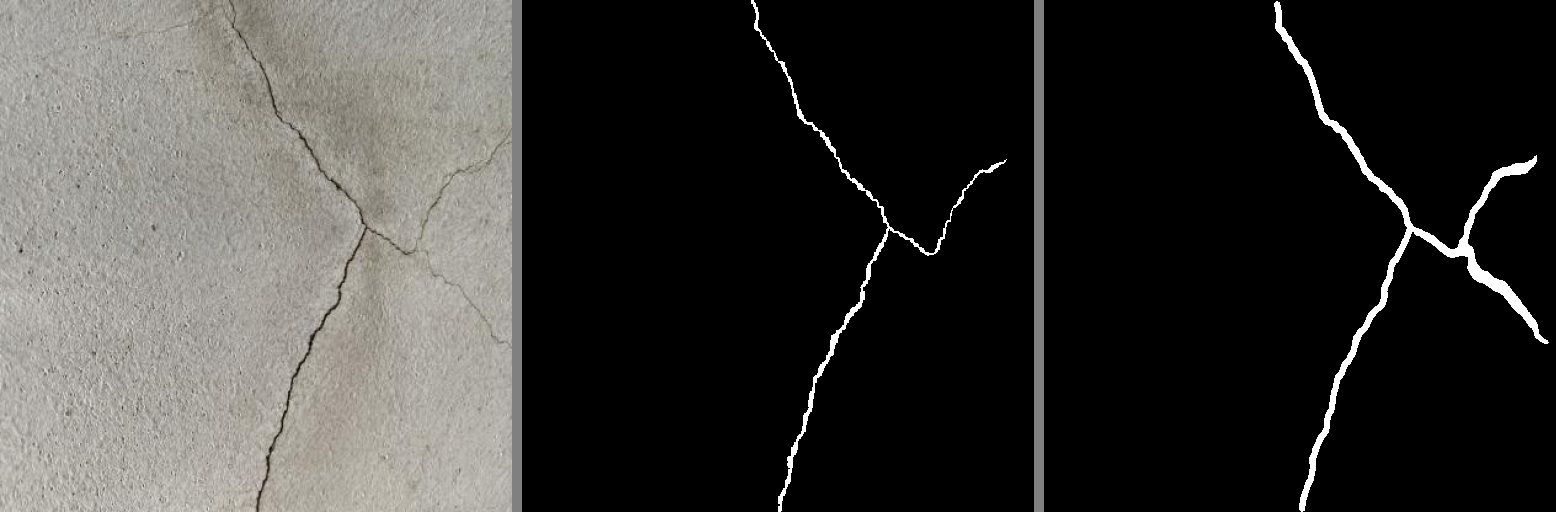

In [40]:
img = '/content/unet_pyt/UNET/results/2426.png'
display(Image(filename= img))